In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from desmin_reconstruction.analysis.ripley import (
    ripley_H_from_L,
    ripley_K,
    ripley_L_from_K,
)
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from tqdm import tqdm


COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00", "actin": "#0000FF"}
LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin", "actin": "Actin"}


In [2]:
df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}

In [3]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [4]:
idx = 15
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )

sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

100%|██████████| 80/80 [00:07<00:00, 10.04it/s]


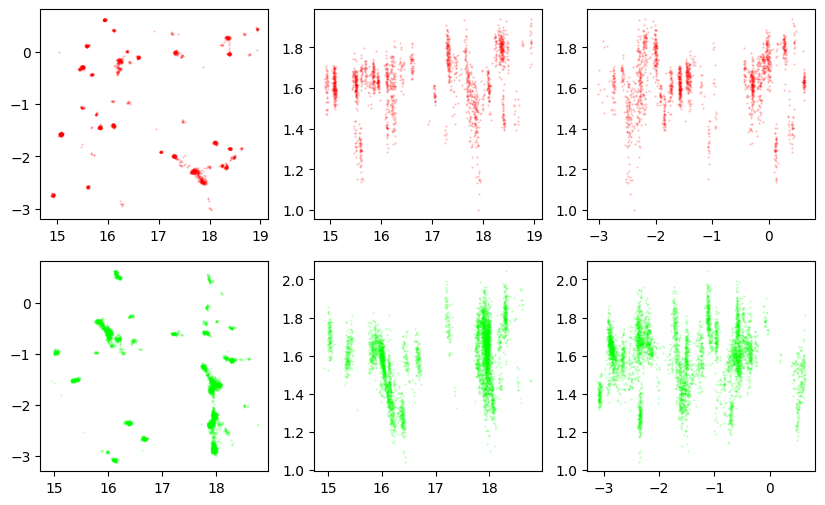

In [5]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


  8%|▊         | 3/40 [00:00<00:01, 25.68it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]


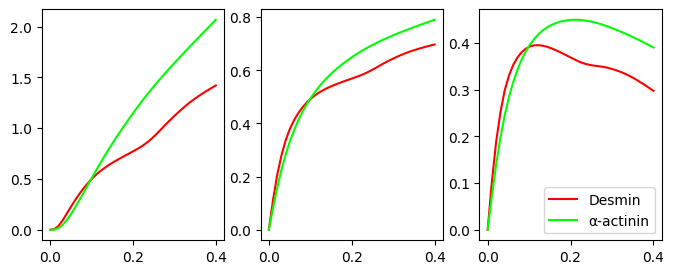

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

r = np.linspace(0, 0.4, 40)

for protein, pts in sq1_final.items():
    k = ripley_K(pts, r, [4.0, 4.0, 1.0])
    l = ripley_L_from_K(k, dim=pts.shape[1])
    h = ripley_H_from_L(l, r)

    axes[0].plot(r, k, color=COLOR_DICT[protein], label=LABEL_DICT[protein])
    axes[1].plot(r, l, color=COLOR_DICT[protein], label=LABEL_DICT[protein])
    axes[2].plot(r, h, color=COLOR_DICT[protein], label=LABEL_DICT[protein])

axes[-1].legend()

In [7]:
r = np.linspace(0, 0.4, 40)
sides = [4.0, 4.0, 1.0]

ripley_K_rois = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}

    ripley_K_rois.append({k: ripley_K(v, r, sides) for k, v in sq1.items()})

K_total = {prot: [r[prot] for r in ripley_K_rois] for prot in ("desmin", "actinin")}
L_total = {prot: [ripley_L_from_K(k_i, 3) for k_i in K] for prot, K in K_total.items()}
H_total = {prot: [ripley_H_from_L(l_i, r) for l_i in L] for prot, L in L_total.items()}

100%|██████████| 16/16 [11:05<00:00, 41.62s/it]


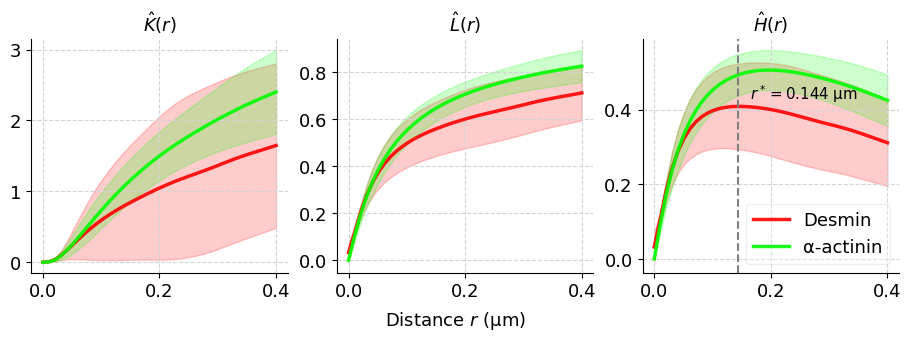

In [9]:
from desmin_reconstruction.plotting import line_and_bandplot


plt.rc("font", size=13)
fig, axes = plt.subplots(1, 3, figsize=(9, 3.3), constrained_layout=True)
for protein in K_total.keys():
    axes[0] = line_and_bandplot(
        axes[0],
        r,
        np.mean(K_total[protein], axis=0),
        np.std(K_total[protein], axis=0),
        color=COLOR_DICT[protein],
        # label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )
    axes[1] = line_and_bandplot(
        axes[1],
        r,
        np.mean(L_total[protein], axis=0),
        np.std(L_total[protein], axis=0),
        color=COLOR_DICT[protein],
        # label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )
    axes[2] = line_and_bandplot(
        axes[2],
        r,
        np.mean(H_total[protein], axis=0),
        np.std(H_total[protein], axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )
idx_max = np.argmax(np.mean(H_total["desmin"], axis=0))
axes[2].axvline(x=r[idx_max], ls="--", color="gray")
axes[2].text(
    r[idx_max] + 0.02,
    np.mean(H_total["desmin"], axis=0)[idx_max] + 0.02,
    f"$r^*={r[idx_max]:.3f}$ μm",
    size="small",
)
for ax, name in zip(axes, ("K", "L", "H")):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")
    ax.set_title(rf"$\hat{{{name}}}(r)$", fontsize="medium")

fig.supxlabel("Distance " + r"$r$" + " (μm)", fontsize="medium")
axes[-1].legend(loc="lower right", framealpha=0.3)
fig.savefig("../figures/supp_fig_3/actinin_ripley.svg", dpi=500)

In [10]:
df = pl.read_csv("../data/results/actin_desmin_600nm_aligned.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("actin", "desmin"))
}

In [11]:
x0s = (3, 7, 7, 11, 11, 11, 11, 15, 15, 15, 19, 19)
y0s = (-2, -1.5, -5.5, -1, -5, -9, -13, -1, -5, -9, -2, -6)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [12]:
r = np.linspace(0, 0.4, 40)
sides = [4.0, 4.0, 1.0]

ripley_K_rois2 = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}

    ripley_K_rois2.append({k: ripley_K(v, r, sides) for k, v in sq1.items()})

K_total2 = {prot: [r[prot] for r in ripley_K_rois2] for prot in ("desmin", "actin")}
L_total2 = {
    prot: [ripley_L_from_K(k_i, 3) for k_i in K] for prot, K in K_total2.items()
}
H_total2 = {
    prot: [ripley_H_from_L(l_i, r) for l_i in L] for prot, L in L_total2.items()
}

100%|██████████| 12/12 [09:19<00:00, 46.66s/it]


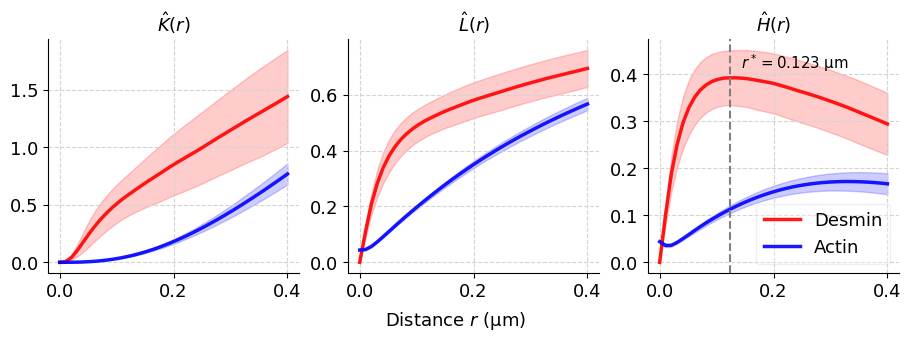

In [13]:
from desmin_reconstruction.plotting import line_and_bandplot


plt.rc("font", size=13)
fig, axes = plt.subplots(1, 3, figsize=(9, 3.3), constrained_layout=True)
for protein in K_total2.keys():
    axes[0] = line_and_bandplot(
        axes[0],
        r,
        np.mean(K_total2[protein], axis=0),
        np.std(K_total2[protein], axis=0),
        color=COLOR_DICT[protein],
        # label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )
    axes[1] = line_and_bandplot(
        axes[1],
        r,
        np.mean(L_total2[protein], axis=0),
        np.std(L_total2[protein], axis=0),
        color=COLOR_DICT[protein],
        # label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )
    axes[2] = line_and_bandplot(
        axes[2],
        r,
        np.mean(H_total2[protein], axis=0),
        np.std(H_total2[protein], axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )
idx_max = np.argmax(np.mean(H_total2["desmin"], axis=0))
axes[2].axvline(x=r[idx_max], ls="--", color="gray")
axes[2].text(
    r[idx_max] + 0.02,
    np.mean(H_total2["desmin"], axis=0)[idx_max] + 0.02,
    f"$r^*={r[idx_max]:.3f}$ μm",
    size="small",
)
for ax, name in zip(axes, ("K", "L", "H")):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")
    ax.set_title(rf"$\hat{{{name}}}(r)$", fontsize="medium")

fig.supxlabel("Distance " + r"$r$" + " (μm)", fontsize="medium")
axes[-1].legend(loc="lower right", framealpha=0.3)
fig.savefig("../figures/supp_fig_3/actin_ripley.svg", dpi=500)

In [14]:
r[np.argmax(np.mean(H_total2["desmin"], axis=0))]

np.float64(0.12307692307692308)

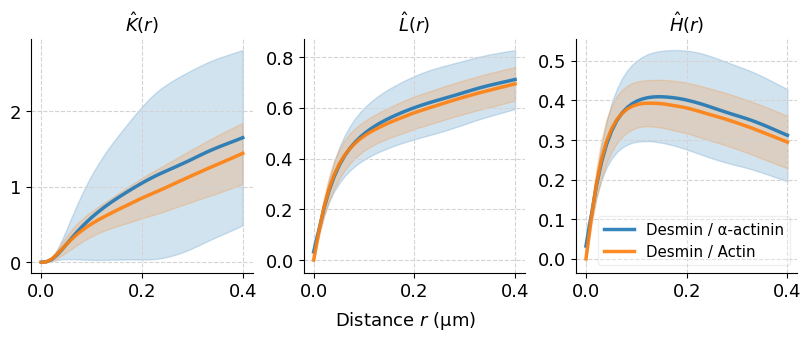

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3.3), constrained_layout=True)
axes[0] = line_and_bandplot(
    axes[0],
    r,
    np.mean(K_total["desmin"], axis=0),
    np.std(K_total["desmin"], axis=0),
    color="tab:blue",
    # label=LABEL_DICT[protein],
    linewidth=2.5,
    alpha=0.9,
    alpha_band=0.2,
)
axes[1] = line_and_bandplot(
    axes[1],
    r,
    np.mean(L_total["desmin"], axis=0),
    np.std(L_total["desmin"], axis=0),
    color="tab:blue",
    # label=LABEL_DICT[protein],
    linewidth=2.5,
    alpha=0.9,
    alpha_band=0.2,
)
axes[2] = line_and_bandplot(
    axes[2],
    r,
    np.mean(H_total["desmin"], axis=0),
    np.std(H_total["desmin"], axis=0),
    color="tab:blue",
    label="Desmin / α-actinin",
    linewidth=2.5,
    alpha=0.9,
    alpha_band=0.2,
)
axes[0] = line_and_bandplot(
    axes[0],
    r,
    np.mean(K_total2["desmin"], axis=0),
    np.std(K_total2["desmin"], axis=0),
    color="tab:orange",
    # label=LABEL_DICT[protein],
    linewidth=2.5,
    alpha=0.9,
    alpha_band=0.2,
)
axes[1] = line_and_bandplot(
    axes[1],
    r,
    np.mean(L_total2["desmin"], axis=0),
    np.std(L_total2["desmin"], axis=0),
    color="tab:orange",
    # label=LABEL_DICT[protein],
    linewidth=2.5,
    alpha=0.9,
    alpha_band=0.2,
)
axes[2] = line_and_bandplot(
    axes[2],
    r,
    np.mean(H_total2["desmin"], axis=0),
    np.std(H_total2["desmin"], axis=0),
    color="tab:orange",
    label="Desmin / Actin",
    linewidth=2.5,
    alpha=0.9,
    alpha_band=0.2,
)
for ax, name in zip(axes, ("K", "L", "H")):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")
    ax.set_title(rf"$\hat{{{name}}}(r)$", fontsize="medium")
axes[-1].legend(loc="lower right", framealpha=0.3, fontsize="small")
fig.supxlabel("Distance " + r"$r$" + " (μm)", fontsize="medium")
fig.savefig("../figures/supp_fig_3/desmin_ripley_comparison.svg", dpi=500)